
---
# Python 人工智能入门 毕业项目
# 利用机器学习模型预测股票走势
## 谢晓阳
---


## 目录
<ul>
<li><a href="#definition">定义</a></li>
<li><a href="#analysis">分析</a></li>
<li><a href="#implementation">实现</a></li>
<li><a href="#result">结果</a></li>
<li><a href="#conclusion">结论</a></li>   
</ul>



---
<a id="definition"></a>
## Ⅰ.定义


### 1.项目概况


大多数人在炒股的时候常常会有一个想法——如果“我”能判断大盘的涨跌，我就可以在合适的时机买入卖出，从而大赚一笔。所以，我准备用机器学习技术尝试着去实现这个想法，尝试对大盘指数进行预测、预测股票走势。
所用的数据集是2006-03-01~2015-03-01的沪市指数日度收盘信息，包括以下字段：交易日、收盘指数、当日最大指数、当日最小指数、成交量、涨跌、涨跌幅。

### 2.问题陈述


使用多元线性回归算法，通过昨日的收盘信息（昨日的 closeIndex、highestIndex、lowestIndex、TurnoverVol、CHG、CHGPct）预测明日的收盘指数(明日的closeIndex)。



### 3.评价指标

指标：平均绝对误差（mean_absolute_error） <br/>
计算方法：$\frac{1}{n}\sum_{i=1}^n{|y_i-\hat{y}_i|}$
<br/>$\hat{y}$ 是预测值，$y$是真实值, $n$是测试集大小<br/>

由于我们需要预测明日的收盘指数(float值)，所以预测值如果离真实值越接近，则预测得越准确。即对于单个数据点来说 $|y-\hat{y}|$ （即 绝对误差） 越小，模型预测越准确。由于测试集包含多个数据点，所以 平均绝对误差 越小，模型预测得越准确。

对**Ⅰ.定义**中问题的思考:

**由于预测股票走势具有非常现实的意义，能够帮助股民增加经济收益，所以我尝试用收盘信息去预测收盘指数。而收盘指数是一个浮点数，所以平均绝对误差越小，说明模型性能越好。依靠多个解释变量预测一个浮点类型的反应变量，非常匹配多元线性回归算法的使用场景。**


---
<a id="analysis"></a>
## Ⅱ.分析



### 1.数据的探索




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sms;
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

%matplotlib inline

df = pd.read_csv("data.csv")
df.drop(columns='Unnamed: 0',inplace=True)

In [2]:
df.head()

,tradeDate,closeIndex,highestIndex,lowestIndex,turnoverVol,CHG,CHGPct
0,2006-03-01,1056.62,1057.69,1049.64,1942573000,3.61,0.003428
1,2006-03-02,1038.67,1056.05,1034.68,2487786100,-17.95,-0.016988
2,2006-03-03,1041.68,1043.42,1029.56,2120053900,3.01,0.002898
3,2006-03-06,1038.87,1044.42,1036.11,1787096300,-2.81,-0.002698
4,2006-03-07,1014.97,1037.98,1013.14,1933651600,-23.90,-0.023006


通过在“优矿”网站上面的“研究数据” → 搜索 DataAPI.MktIdxdGet()，可得各列的具体含义：

列名 | 含义
---|---
tradeDate | 交易日
closeIndex | 收盘指数
highestIndex | 当日最大指数
lowestIndex | 当日最小指数
TurnoverVol | 成交量
CHG | 涨跌，收盘-昨收盘
CHGPct | 涨跌幅，(收盘/昨收盘)-1

In [3]:
df.shape

(2187, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2187 entries, 0 to 2186
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   tradeDate     2187 non-null   object 
 1   closeIndex    2187 non-null   float64
 2   highestIndex  2187 non-null   float64
 3   lowestIndex   2187 non-null   float64
 4   turnoverVol   2187 non-null   int64  
 5   CHG           2187 non-null   float64
 6   CHGPct        2187 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 119.7+ KB


In [5]:
df.describe()

,closeIndex,highestIndex,lowestIndex,turnoverVol,CHG,CHGPct
count,2187.000000,2187.000000,2187.000000,2.187000e+03,2187.000000,2187.000000
mean,2787.469758,2816.014321,2752.490402,6.939017e+09,1.152186,0.000732
std,897.538722,910.123885,881.555628,5.389863e+09,58.216027,0.018595
min,1004.340000,1010.910000,999.930000,1.134803e+09,-391.860000,-0.092400
25%,2287.135000,2307.990000,2259.585000,3.998628e+09,-21.330000,-0.008226
50%,2608.570000,2628.700000,2584.760000,5.794680e+09,2.900000,0.001100
75%,3222.340000,3253.935000,3178.845000,8.159082e+09,27.075000,0.010603
max,5877.200000,5891.720000,5815.610000,6.328746e+10,378.180000,0.093418


从上面的df.describe()结果可以看到，CHG的25%、50%、75%分位分别是-21.33、2.9、27.075，closeIndex的最大值为5877.2，由此可知明日的收盘指数与昨日的收盘指数大部分情况下应该是比较接近的数字。

In [6]:
# 验证原数据集的CHG数据是否正确

df_empty = df.iloc[0:1].copy()
df_empty[['tradeDate', 'closeIndex', 'highestIndex', 'lowestIndex', 'turnoverVol', 'CHG', 'CHGPct']] = 0
df_yesterday = df_empty.append(df, ignore_index = True)
df_yesterday.drop([2187],inplace=True)

df['CHG_m'] = df['closeIndex']-df_yesterday['closeIndex']
df['CHG_m'] = df['CHG_m'].round(2) # 自己计算的CHG列
df[(df['CHG'] != df['CHG_m'])] # 查看哪一行数据是与计算出的列不相等的

,tradeDate,closeIndex,highestIndex,lowestIndex,turnoverVol,CHG,CHGPct,CHG_m
0,2006-03-01,1056.62,1057.69,1049.64,1942573000,3.61,0.003428,1056.62


通过自己计算的CHG（即CHG_m列），与原数据集的CHG数据做对比，发现只有第一行不相等，而这个情况是正常的，因为原数据集没有2006-02-28（最早tradeDate的前一天）的数据。所以验证得原数据集的CHG数据没有错误值。

In [7]:
# 验证原数据集的CHGPct数据是否正确

df['CHGPct_m'] = (df['closeIndex']/df_yesterday['closeIndex'])-1
df['CHGPct_m'] = df['CHGPct_m'].round(6) # 自己计算的CHGPct列
df['CHGPct_round'] = df['CHGPct'].round(6) #用于存储原始CHGPct列四舍五入后的结果
df[(df['CHGPct_round'] != df['CHGPct_m'])] # 查看哪一行数据是与计算出的列不相等的

,tradeDate,closeIndex,highestIndex,lowestIndex,turnoverVol,CHG,CHGPct,CHG_m,CHGPct_m,CHGPct_round
0,2006-03-01,1056.62,1057.69,1049.64,1942573000,3.61,0.003428,1056.62,inf,0.003428


与CHG列类似，通过自己计算的CHGPct（即CHGPct_m列），与原数据集的CHGPct数据做对比，发现只有第一行不相等，而这个情况是正常的，因为原数据集没有2006-02-28（最早tradeDate的前一天）的数据。所以验证得原数据集的CHGPct数据没有错误值。

### 2.探索性可视化




In [8]:
# 由于我们是根据昨天的收盘信息预测明天的closeIndex，所以我们加入新列closeIndex_tomorrow（即 反应变量），代表明天的closeIndex

df_tomorrow = df.copy()
df_tomorrow.drop([0], inplace=True)
tomorrow_closeIndex = np.append(df_tomorrow['closeIndex'].values,float("nan"))
df['closeIndex_tomorrow']= tomorrow_closeIndex

Text(0.5, 1.0, 'frequency of closeIndex')

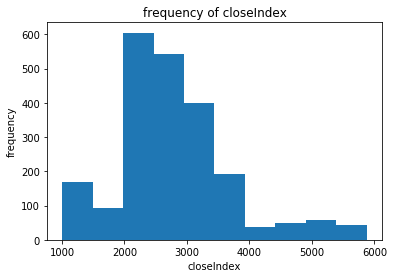

In [9]:
# 接下来的6个代码cell都是画某一列数据的直方图

plt.hist(data = df, x = 'closeIndex')

plt.xlabel('closeIndex')
plt.ylabel('frequency')
plt.title('frequency of closeIndex')

Text(0.5, 1.0, 'frequency of highestIndex')

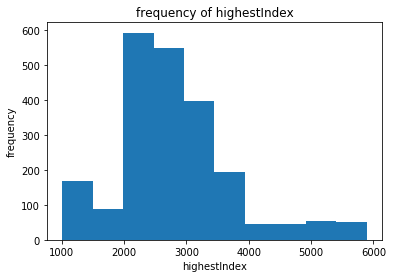

In [10]:
plt.hist(data = df, x = 'highestIndex')

plt.xlabel('highestIndex')
plt.ylabel('frequency')
plt.title('frequency of highestIndex')

Text(0.5, 1.0, 'frequency of lowestIndex')

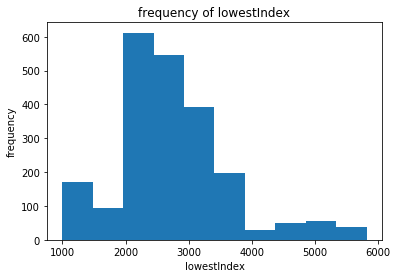

In [11]:
plt.hist(data = df, x = 'lowestIndex')

plt.xlabel('lowestIndex')
plt.ylabel('frequency')
plt.title('frequency of lowestIndex')

Text(0.5, 1.0, 'frequency of turnoverVol')

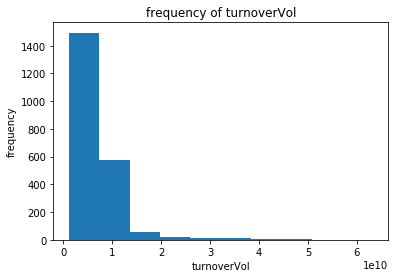

In [12]:
plt.hist(data = df, x = 'turnoverVol')

plt.xlabel('turnoverVol')
plt.ylabel('frequency')
plt.title('frequency of turnoverVol')

Text(0.5, 1.0, 'frequency of CHG')

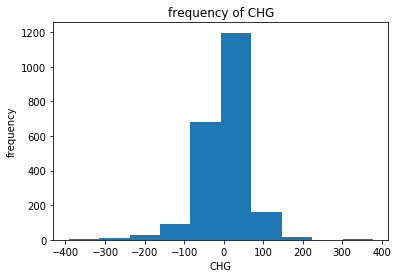

In [13]:
plt.hist(data = df, x = 'CHG')

plt.xlabel('CHG')
plt.ylabel('frequency')
plt.title('frequency of CHG')

Text(0.5, 1.0, 'frequency of CHGPct')

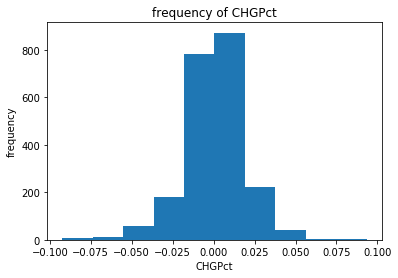

In [14]:
plt.hist(data = df, x = 'CHGPct')

plt.xlabel('CHGPct')
plt.ylabel('frequency')
plt.title('frequency of CHGPct')

以上6个代码cell展示了closeIndex、highestIndex、lowestIndex、turnoverVol、CHG、CHGPct的直方图，让我们对这6个变量的分布状况有一个直观认识，而且直方图还能够让我们观察是否有离群值或异常值。<br/>
我们可以看到，closeIndex、highestIndex、lowestIndex、turnoverVol这4个变量有点右偏，但并没有特别异常的值。而CHG、CHGPct的直方图只是让我们有一个直观的分布认识，并不需要再去验证值是否异常（因为我们在“1.数据的探索”阶段已经自己分别计算过这两个值，经过对比，并没有错误。）。<br/>
closeIndex、highestIndex、lowestIndex大部分都落在2000\~4000这一范围内，而turnoverVol大多落在1.5e+10内，而CHG大多落在-100\~100这个范围内。这表明昨天的closeIndex跟今天的closeIndex大部分情况下相差并不会很多（CHGPct的直方图也证明了这一点）。

(0, 4000)

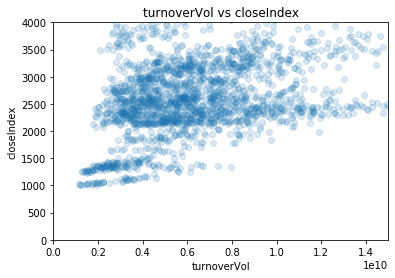

In [15]:
# turnoverVol与closeIndex的散点图

plt.scatter(data = df, x = 'turnoverVol', y = 'closeIndex', alpha = 1/6)

plt.xlabel('turnoverVol')
plt.ylabel('closeIndex')
plt.title('turnoverVol vs closeIndex')
plt.xlim(0,1.5e10) # turnoverVol大多落在1.5e+10内
plt.ylim(0,4000) # closeIndex大部分都落在4000内

上图描绘了turnoverVol vs closeIndex的散点图。<br/>
从图中对turnoverVol和closeIndex的关系有一个直观认识，从而对机器学习模型应该有的结果有一个大概的猜测。<br/>
从图中颜色较深的区域可以看到，随着turnoverVol的增长，closeIndex是有一点点增长的趋势的（虽然不是特别明显）。这意味着模型训练之前，需要计算VIF，考虑这两个变量之间是否存在多重共线性问题。

(-100, 100)

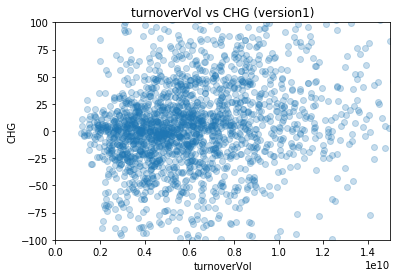

In [16]:
# turnoverVol与CHG的散点图

plt.scatter(data = df, x = 'turnoverVol', y = 'CHG', alpha = 1/4)

plt.xlabel('turnoverVol')
plt.ylabel('CHG')
plt.title('turnoverVol vs CHG (version1)')
plt.xlim(0,1.5e10) # turnoverVol大多落在1.5e+10内
plt.ylim(-100,100) # CHG大多落在-100~100这个范围内

(-50, 50)

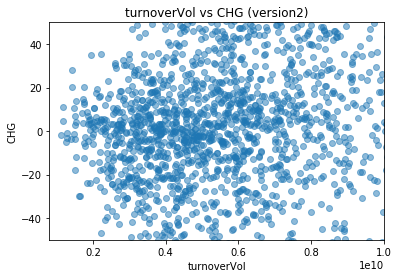

In [17]:
# turnoverVol与CHG的散点图（缩小至数据点较多的区域）

plt.scatter(data = df, x = 'turnoverVol', y = 'CHG', alpha = 1/2)

plt.xlabel('turnoverVol')
plt.ylabel('CHG')
plt.title('turnoverVol vs CHG (version2)')
plt.xlim(0.08e10,1e10) # 根据“turnoverVol vs CHG (version1)”散点图进一步查看point较密集区域
plt.ylim(-50,50) # 根据“turnoverVol vs CHG (version1)”散点图进一步查看point较密集区域

可以看到，turnoverVol与CHG的关系并不是十分明显。意味着这两个变量存在多重共线性问题的概率比较低。

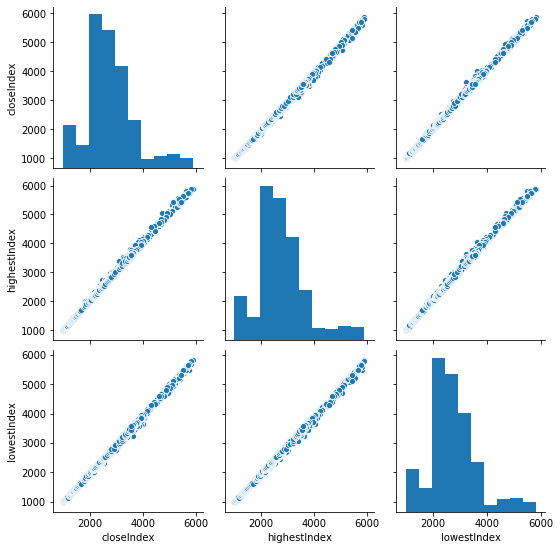

In [18]:
# closeIndex、highestIndex、lowestIndex间的散点图

sb.pairplot(df[['closeIndex', 'highestIndex', 'lowestIndex']])

从上图可以看到，closeIndex、highestIndex、lowestIndex之间居然明显的线性关系，所以到模型训练阶段，这3个变量间一定存在多重共线性问题。

(-0.05, 0.05)

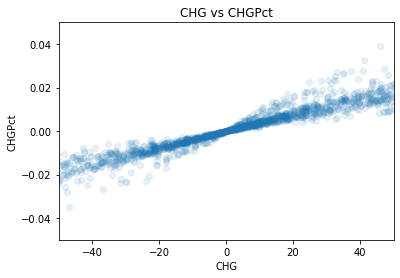

In [19]:
# CHG与CHGPct的散点图

plt.scatter(data = df, x = 'CHG', y = 'CHGPct', alpha = 1/10)

plt.xlabel('CHG')
plt.ylabel('CHGPct')
plt.title('CHG vs CHGPct')
plt.xlim(-50,50) # 查看point较密集区域
plt.ylim(-0.05,0.05) # 查看point较密集区域

从上图可以看到，CHG、CHGPct之间有明显的线性关系，所以到模型训练阶段，这2个变量间的多重共线性问题需要考虑。

Text(0.5, 1.0, 'closeIndex vs closeIndex_tomorrow')

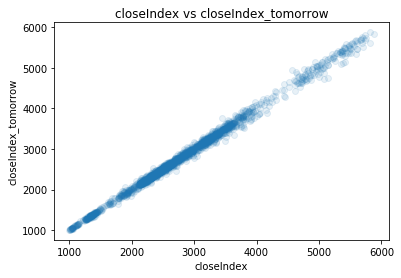

In [20]:
# closeIndex与closeIndex_tomorrow的散点图

plt.scatter(data = df, x = 'closeIndex', y = 'closeIndex_tomorrow', alpha = 1/10)

plt.xlabel('closeIndex')
plt.ylabel('closeIndex_tomorrow')
plt.title('closeIndex vs closeIndex_tomorrow')

可以看到，closeIndex与closeIndex_tomorrow有明显的线性关系，这说明了我们使用多元线性回归模型是合理的。这也让我们对模型应该有的结果有一个大概的认识。

(800000000.0, 12500000000.0)

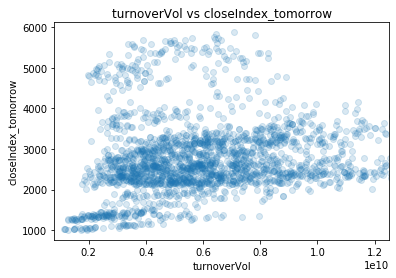

In [21]:
# turnoverVol与closeIndex_tomorrow的散点图

plt.scatter(data = df, x = 'turnoverVol', y = 'closeIndex_tomorrow', alpha = 1/6)

plt.xlabel('turnoverVol')
plt.ylabel('closeIndex_tomorrow')
plt.title('turnoverVol vs closeIndex_tomorrow')
plt.xlim(0.08e10,1.25e10)

对turnoverVol和closeIndex_tomorrow的关系有一个直观认识，发现这两个变量间的线性关系并不是特别明显。

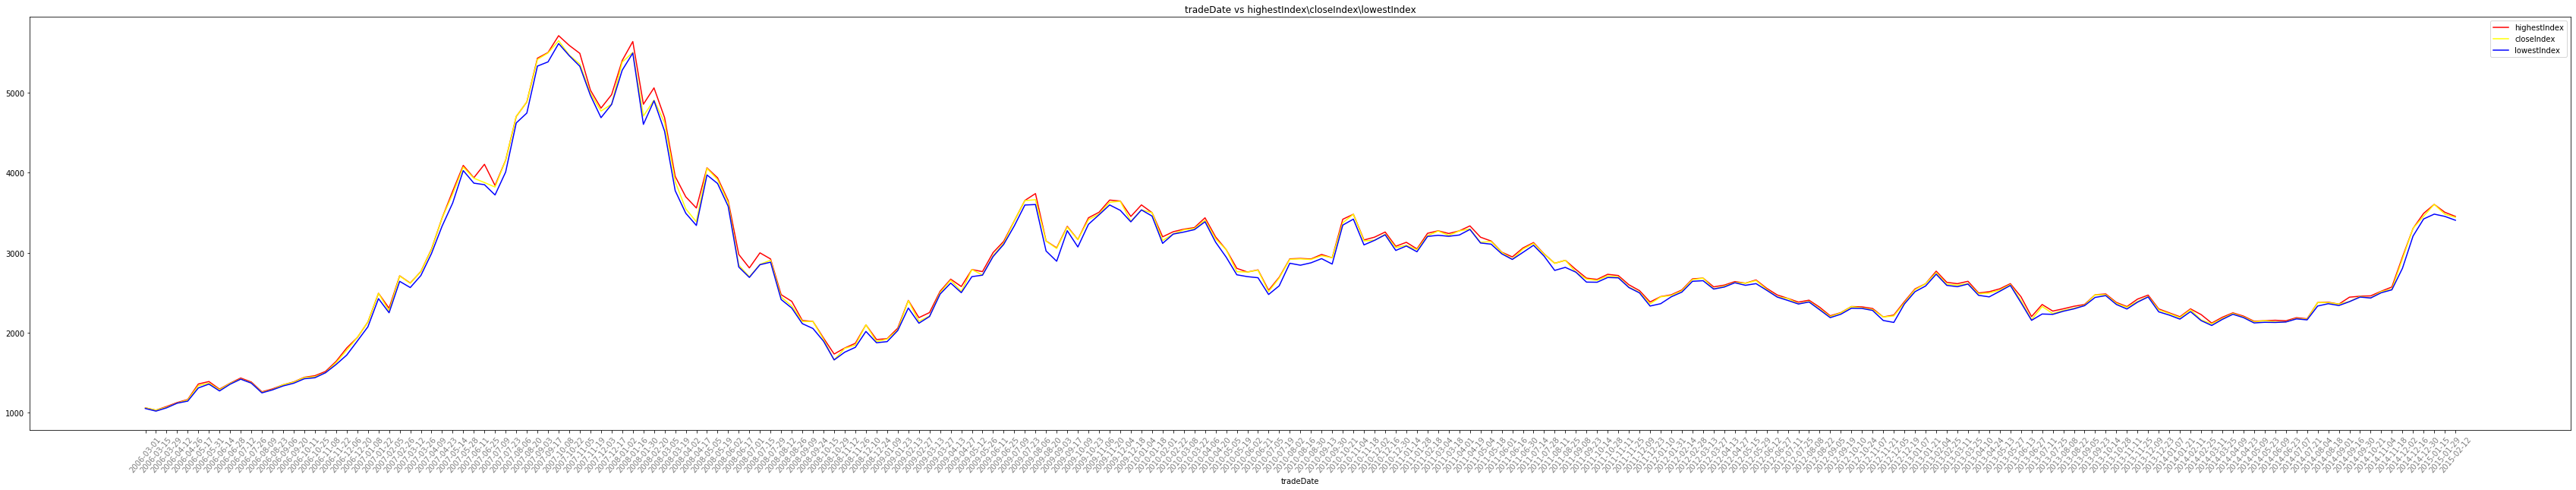

In [22]:
# highestIndex、closeIndex、lowestIndex随着时间的折线图
# （由于数据集有2000多行，有点多，所以我们以10行为间隔）

plt.figure(figsize=(60,10));
plt.errorbar(data = df.iloc[range(0,df.shape[0]+1,10)], x = 'tradeDate', y = 'highestIndex',color="red",label="highestIndex");
plt.errorbar(data = df.iloc[range(0,df.shape[0]+1,10)], x = 'tradeDate', y = 'closeIndex',color="yellow",label="closeIndex");
plt.errorbar(data = df.iloc[range(0,df.shape[0]+1,10)], x = 'tradeDate', y = 'lowestIndex',color="blue",label="lowestIndex");
plt.xlabel('tradeDate');
plt.title('tradeDate vs highestIndex\closeIndex\lowestIndex');
plt.xticks(alpha=0.5, rotation=50);
plt.legend();


从上图可以看到highestIndex、closeIndex、lowestIndex随着时间的走势图，我们可以对指数的走势有一个大概的直观感觉。并且我们还可以看到，3种不同颜色的线几乎重合，也代表着这三列的数值相差不大。

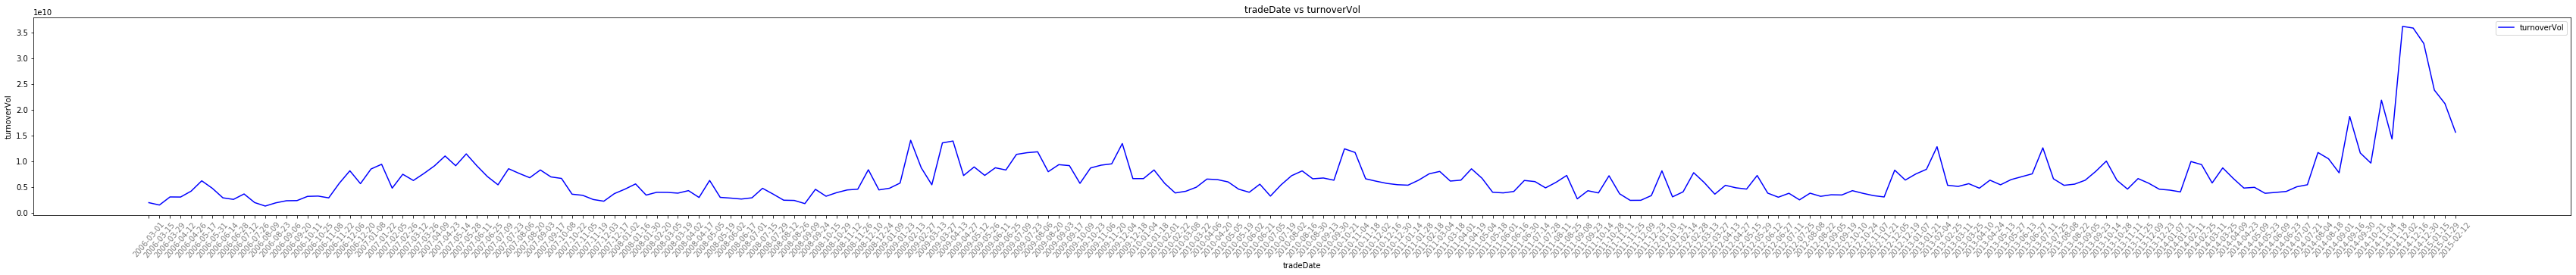

In [23]:
# turnoverVol（成交量）随着时间的折线图
# （由于数据集有2000多行，有点多，所以我们以10行为间隔）

plt.figure(figsize=(60,4.8));
plt.errorbar(data = df.iloc[range(0,df.shape[0]+1,10)], x = 'tradeDate', y = 'turnoverVol',color="blue",label="turnoverVol");
plt.xlabel('tradeDate')
plt.ylabel('turnoverVol')
plt.title('tradeDate vs turnoverVol')
plt.xticks(alpha=0.5, rotation=50);
plt.legend();

从turnoverVol（成交量）随着时间的走势图我们可以看到，从2014-9-1开始成交量相对于以往开始变得很大，是之前的2-3倍

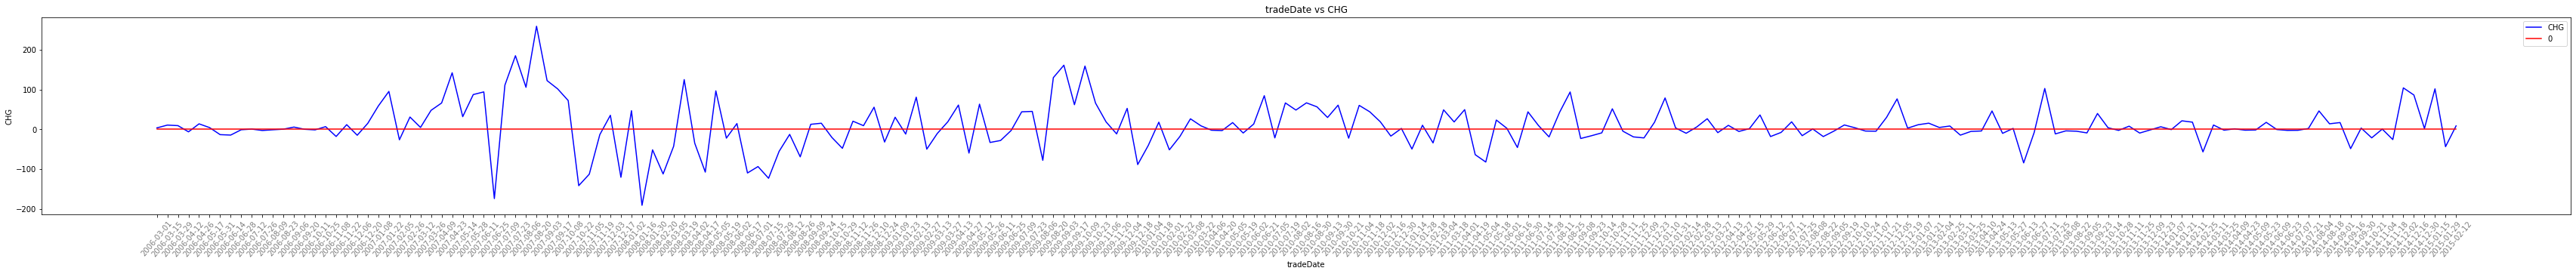

In [24]:
# CHG（涨跌）随着时间的折线图
# （由于数据集有2000多行，有点多，所以我们以10行为间隔。红色线为数值为0的线，作为参考。）

plt.figure(figsize=(60,4.8));
plt.errorbar(data = df.iloc[range(0,df.shape[0]+1,10)], x = 'tradeDate', y = 'CHG',color="blue",label="CHG");
plt.errorbar(data = df.iloc[range(0,df.shape[0]+1,10)], x = 'tradeDate', y = 0,color="red",label="0");
plt.xlabel('tradeDate')
plt.ylabel('CHG')
plt.title('tradeDate vs CHG')
plt.xticks(alpha=0.5, rotation=50);
plt.legend();

从CHG（涨跌）随着时间的走势图我们可以对CHG的变化有个直观认识，红色线代表数值为0，红色线以上代表涨，红色线以下代表跌

### 3.算法和技术


我想实现的事情：通过昨日的 closeIndex、highestIndex、lowestIndex、TurnoverVol、CHG、CHGPct预测明日的closeIndex。这里有多个解释变量（定量变量：float和int），一个反应变量（定量变量：float）。而多元线性回归算法恰好是通过多个解释变量，对一个定量变量进行回归。所以多元线性回归算法很适合用来解决这个问题。<br/>

多元线性回归算法简介：<br/>
多元线性回归线记为：$\hat{y}=b_0+b_{1}x_1+b_{2}x_2+……+b_{n}x_n$ <br/>
其中：<br/>
$\hat{y}为回归线反应变量的预测值$（这里对应closeIndex的预测值）<br/>
$b_0为截距$<br/>
$b_{1}、b_{2}……b_{n}为斜率$<br/>
$x_{1}、x_{2}……x_{n}为解释变量$（这里对应我们的closeIndex、highestIndex、lowestIndex、TurnoverVol、CHG、CHGPct）<br/>
$y 为数据集某个数据点的实际反应变量值$（这里对应数据集里的closeIndex）<br/>
然后我们使用最小二乘法，可以找出一组$b_{0}、b_{1}、b_{2}……b_{n}使\sum_{i=1}^n{(y_i-\hat{y}_i)^2}$最小化，此时得到我们的结果回归线。由于利用此回归线函数在已有的所有数据内可使预测值与真实值的差距最小，所以我们便可以用它来预测其他的解释变量相对应的反应变量是多少，从而对真实的反应变量做出估计和预测

另外我们采用第三方库statsmodels提供的线性回归模型最小二乘法的API

一些参考资料：<br/>
最小二乘法：https://baike.baidu.com/item/%E6%9C%80%E5%B0%8F%E4%BA%8C%E4%B9%98%E6%B3%95 <br/>
多元线性回归：https://baike.baidu.com/item/%E5%A4%9A%E5%85%83%E7%BA%BF%E6%80%A7%E5%9B%9E%E5%BD%92/10702248 <br/>
statsmodels提供的线性回归模型最小二乘法：https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html


对**Ⅱ.分析**中问题的思考：

**在这章节中，我们可以看到数据有2000行左右，感兴趣的列也都是定量变量，没有分类变量。原数据集的质量较好，经过探索，并没有错误值、异常值。同时也大概了解了数据集各列的分布情况。<br/>
在可视化探索方面，我们能够从视觉上看到数据集各列的分布情况、变量与变量之间的关系，对数据列和数据列之间有了很好的直观感觉认识。<br/>
经过数据集的探索，我们更确定了我们所使用的算法——多元线性回归的合理性。**


---
<a id="implementation"></a>
## Ⅲ. 实现


### 1.数据预处理




通过“Ⅱ.分析”章节，我们可以看到原数据集质量很好，并没有错误值、异常值等缺陷需要处理。并且由于我们在“探索性可视化”的时候有探索解释变量与反应变量的可视化，所以我们已经在dataframe中加入了需要的closeIndex_tomorrow列。唯一的小问题是：因为对于最后一天，我们没有下一天的数据，所以数据集中最后一行的closeIndex_tomorrow为NaN，所以我们删除此行，保证数据集中所有行的数据都有效。

In [25]:
# 因为对于最后一天，我们没有下一天的数据，所以数据集中最后一行的closeIndex_tomorrow为NaN，所以我们删除此行，保证数据集中所有行的数据都有效。

df.drop(index=[2186], axis=0, inplace=True)

### 2.执行过程




In [26]:
# 在可视化探索环节，我们看到了有多重共线性问题的可能，所以我们先计算VIF

y, X = dmatrices('closeIndex_tomorrow ~ closeIndex + highestIndex + lowestIndex + turnoverVol + CHG + CHGPct' , df, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,12.017719,Intercept
1,3822.543594,closeIndex
2,1895.712225,highestIndex
3,1155.083590,lowestIndex
4,1.066074,turnoverVol
5,14.581756,CHG
6,10.698798,CHGPct


In [27]:
# 结合vif的计算结果以及可视化的探索结果，决定删除highestIndex、lowestIndex、CHGPct这三列，在没有这3列的情况下，重新计算vif

y, X = dmatrices('closeIndex_tomorrow ~ closeIndex + turnoverVol + CHG' , df, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,11.349978,Intercept
1,1.023453,closeIndex
2,1.034098,turnoverVol
3,1.010929,CHG


In [28]:
# 从上面的vif结果，我们可以看到，所用的列没有多重共线性问题了。接下来，我们拟合多元线性回归模型。

In [29]:
# 划分出训练集和测试集
df['intercept'] = 1 # 添加截距
X = df[['intercept', 'closeIndex', 'turnoverVol', 'CHG']][:-1] # [:-1] 保证解释变量在反应变量的前一天，从而达到使用过去的数据去预测未来的数据
y = df['closeIndex'][1:] # [1:] 保证反应变量在解释变量的后一天，从而达到使用过去的数据去预测未来的数据
result_model_seed = 42
result_model_test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=result_model_test_size, random_state=result_model_seed)

# 创建模型并训练模型，然后查看结果

mlr = sms.OLS(y_train.values, X_train[['intercept', 'closeIndex', 'turnoverVol', 'CHG']])
results_mlr = mlr.fit()
results_mlr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.369e+05
Date:                Wed, 29 Apr 2020   Prob (F-statistic):               0.00
Time:                        18:34:05   Log-Likelihood:                -9584.2
No. Observations:                1748   AIC:                         1.918e+04
Df Residuals:                    1744   BIC:                         1.920e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       7.5504      4.678      1.614      0.107      -1.625      16.726
closeIndex      0.9958      0.002    632.930      0.000       0.993       0.999
turnoverVol  8.566e-10   2.54e-10      3.370      0.001    3.58e-10    1.36e-09
CHG             0.0106      0.024      0.450      0.653      -0.036       0.057
==============================================================================
Omnibus:                      299.983   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2828.095
Skew:                          -0.508   Prob(JB):                         0.00
Kurtosis:                       9.148   Cond. No.                     3.00e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  3e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


### 3.完善


在“2.执行过程”里，我们的训练测试集的划分是打乱了数据的顺序的，而我们其实是用以前的数据去预测未来的数据，所以最理想的划分方式是所有的训练集的时间都早于测试集。所以在这里，我们以最理想的方式重新划分训练测试集，并训练模型。

In [30]:
# 划分出训练集和测试集
df['intercept'] = 1 # 添加截距
X = df[['intercept', 'closeIndex', 'turnoverVol', 'CHG']][:-1] # [:-1] 保证解释变量在反应变量的前一天，从而达到使用过去的数据去预测未来的数据
y = df['closeIndex'][1:] # [1:] 保证反应变量在解释变量的后一天，从而达到使用过去的数据去预测未来的数据
result_model_test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=result_model_test_size, shuffle=False) # shuffle=False，保证训练集早于测试集

# 创建模型并训练模型，然后查看结果
mlr = sms.OLS(y_train.values, X_train[['intercept', 'closeIndex', 'turnoverVol', 'CHG']])
results_mlr = mlr.fit()
results_mlr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.398e+05
Date:                Wed, 29 Apr 2020   Prob (F-statistic):               0.00
Time:                        18:34:05   Log-Likelihood:                -9700.0
No. Observations:                1748   AIC:                         1.941e+04
Df Residuals:                    1744   BIC:                         1.943e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       3.9846      5.146      0.774      0.439      -6.109      14.079
closeIndex      0.9960      0.002    630.868      0.000       0.993       0.999
turnoverVol  1.409e-09   5.43e-10      2.597      0.009    3.45e-10    2.47e-09
CHG             0.0175      0.024      0.729      0.466      -0.030       0.065
==============================================================================
Omnibus:                      260.839   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1816.175
Skew:                          -0.496   Prob(JB):                         0.00
Kurtosis:                       7.894   Cond. No.                     2.25e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.25e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

对**Ⅲ. 实现**中问题的思考

**首先我们没有数据集中最后一天的下一天的日度收盘信息，所以对于最后一行数据，closeIndex_tomorrow值为NaN，为了保证数据集所有数据的有效性，我们选择删除了最后一天的数据。<br/>
而在可视化探索环节，我们已经预知了多重共线性问题的可能，所以在拟合前就通过vif的结果删除了存在问题的列，并且重新计算vif，查看之后的vif结果是否在我们认为的合理范围之内。事实证明，之后的vif结果很棒！<br/>
接着我们便使用多元线性回归模型拟合数据，然后查看结果。该结果也很棒！**


---
<a id="result"></a>
## IV. 结果


### 模型的评价与验证




In [31]:
# 这里我们使用 K-fold cross-validation 来评价模型 （K == 4）
# K-fold索引获取函数来自sklearn
# 参考自：https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold

df['intercept'] = 1 # 添加截距
maes = []
kf = KFold(n_splits=4)
X = df[['intercept', 'closeIndex', 'turnoverVol', 'CHG']][:-1] # [:-1] 保证解释变量在反应变量的前一天，从而达到使用过去的数据去预测未来的数据
y = df['closeIndex'][1:] # [1:] 保证反应变量在解释变量的后一天，从而达到使用过去的数据去预测未来的数据
for train_indexs, test_indexs in kf.split(X):
    X_train = X.iloc[train_indexs]
    y_train = y.iloc[train_indexs]
    X_test = X.iloc[test_indexs]
    y_test = y.iloc[test_indexs]
    
    mlr_cv = sms.OLS(y_train.values, X_train[['intercept', 'closeIndex', 'turnoverVol', 'CHG']]) #cv是 cross validation 的缩写
    results_mlr_cv = mlr_cv.fit()
    
    preds = results_mlr_cv.predict(X_test[['intercept', 'closeIndex', 'turnoverVol', 'CHG']])
    
    mae = mean_absolute_error(y_test.values, preds.values)
    maes.append(mae)

(0, 60)

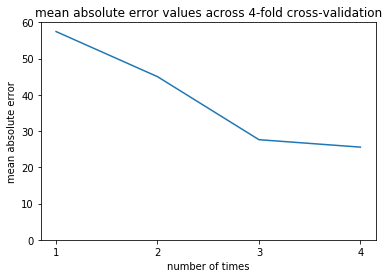

In [32]:
# 画出 4-fold cross-validation 中 绝对平均误差的变化情况

plt.plot(range(1,5), maes)
plt.xticks(range(1,5),range(1,5))
plt.xlabel('number of times')
plt.ylabel('mean absolute error')
plt.title('mean absolute error values across 4-fold cross-validation')
plt.ylim(0,60)

In [33]:
# 4-fold cross-validation中，绝对平均误差的所有值
maes

[57.4648309694717, 45.01814715161604, 27.62457378940208, 25.57100075102669]

In [34]:
# 4-fold cross-validation中，绝对平均误差的平均值、标准差
np.mean(maes), np.std(maes)

(38.91963816537913, 13.104203410294486)

如代码所示，这里我们使用了4-fold cross-validation，得出平均的mae为38.92，标准差为13.10。说明训练数据和测试数据的不同划分，对mae还是有一定的影响。

对**IV. 结果**中问题的思考



**我们使用了4-fold cross-validation，可以看到得出的mae一次比一次小。接下来分析下可能出现这种情况的原因：**
![kfold](kfold.png)
**如上图所示，4-fold是把数据连续分成4份，测试集依次使用第1份、第2份、第3份、第4份，这样造成的结果是随着验证的轮次越往后，在训练集里面就拥有越多的 比测试集日期更早的数据（比如在第一轮的训练测试集划分上，所有的训练集数据都晚于测试集；而在最后一轮的训练测试集划分上，所有的训练集数据都早于测试集）。而我们实际的应用情况是所有用来训练模型的数据都一定早于接下来要预测的数据（因为我们是对未来的大盘指数做预测），所以在4-fold cross-validation的结果里，最后一轮的验证最能代表真实情况。而最后一轮的mae为25.57**


---
<a id="conclusion"></a>
## V. 项目结论



### 结果可视化





In [35]:
# 结果模型在测试集上的绝对误差

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=result_model_test_size, shuffle=False)
preds = results_mlr.predict(X_test[['intercept', 'closeIndex', 'turnoverVol', 'CHG']])
abs_errs = np.abs(preds.values - y_test.values) # 测试集的绝对误差值

In [37]:
# 现在模拟10,000次有放回抽样，并取每个样本的平均绝对误差。

means = np.ndarray(shape=(10000,))
for i in range(10000):
    samples = abs_errs[np.random.randint(low=0, high=abs_errs.size, size=abs_errs.size)]
    means[i] = samples.mean()

Text(0.5, 1.0, 'frequency of mae')

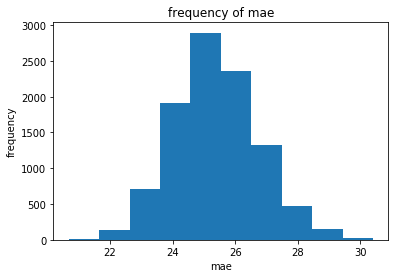

In [38]:
# 自助抽样分布的平均绝对误差的直方图

plt.hist(means)
plt.xlabel('mae')
plt.ylabel('frequency')
plt.title('frequency of mae')

从上图的抽样分布我们可以看到，平均绝对误差大部分落在23~27之间

In [39]:
# 拉出95％的置信区间

np.percentile(a=means, q= 2.5), np.percentile(a=means, q= 97.5)

(22.824358631208458, 28.143653251514287)

结论：通过自助法的抽样分布，我们可以知道，结果模型总体中平均绝对误差95%置信区间为22.86~28.09



### 对项目的思考




项目的背景是机器学习的预测功能和现实中的炒股，自然想把两者结合起来。通过观察了数据集的每列及其含义，选择通过6个定量变量去预测一个定量变量（即收盘指数），自然而然想到了多元线性回归模型。而由于反应变量是定量变量，所以预测值与实际值数字相差越小，说明模型预测能力越好，所以采用平均绝对误差指标来衡量模型的性能。<br/>
确定了想要解决的问题后，马上对拥有的数据进行了分析和了解。有通过pandas查看数据各项指标的，有用可视化查看数据分布和数据间关系的。对数据进行分析了解后，即可知道数据的缺陷，为下一阶段数据预处理打下基础。也是因为对数据进行了了解，更确定所使用的模型——多元线性回归模型的合理性。<br/>
接着使用探索数据了解到的数据缺陷，对数据进行预处理。由于我们的数据集原始数据很好、并且探索过程的可视化做得很全，已经把部分需要的列加入进数据集里面了，所以数据预处理 只需要把含有NaN值的最后一行删除掉就好了。由于多元线性回归模型入参比较简单（给入训练数据即可），在通过vif去掉多余解释变量后，即可直接训练并得到想要的模型。<br/>
得到结果模型以后，我们需要验证此模型的可靠性和稳定性。所以采用了交叉验证方法，计算每一次的平均绝对误差，发现模型的指标平均值和标准差都在一个合理的范围内，所以这个模型对于我们来说是可以接受的。<br/>
最后我们通过自主法的抽样分布，得出了最终结论——模型总体中平均绝对误差95%置信区间为22.86~28.09<br/>
		
项目比较有意思和困难的地方是需要想到通过使用置信区间和自助法抽样分布来得出最终模型的总体表现。<br/>
		
最终结果还算符合期望，如果在现实场景中，能够忍受22.86~28.09的误差，那么这个模型是可以解决预测问题的。<br/>



### 需要作出的改进


关于可以做出的改进的思考：<br/>
对于收盘指数预测问题，其实离你需要预测数据的日期越近的数据，对你预测的结果越有价值。这种问题一个很好的解决办法是使用时间循环神经网络，采用长短期记忆网络（LSTM，Long Short-Term Memory）应该能够得到平均绝对误差更小的模型。<br/>
另外我认为仅仅通过现有的7列数据（tradeDate、closeIndex、highestIndex、lowestIndex、turnoverVol、CHG、CHGPct）实现对股票的预测还是有难度的，因为影响股票收盘指数的不仅仅是这7个值，还有很多其他重要因素，比如世界上是否有大的影响经济的事件发生、每个公司的稳定度、股民的观念、股民的平均年龄、股民的健康程度、犯罪率、生育率、幸福指数等等。<br/>
我想如果能把LSTM网络和一些其他能够影响股市的因素的数据加进来，得到的预测效果会更好。

对**V. 结论**中问题的思考

**通过“V. 结论”，更了解了现有结果是怎样的，也对多元线性回归的应用有了更深的认识，同时也知道了现有模型、数据的局限性，使自己思考到如何能够得到更好的预测结果以及当今时代数据的重要性。对以后的机器学习之路和AI发展，充满了期待。**
